In [2]:
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import MinMaxScaler

In [3]:
TRAIN_DATASET_PATH = 'data/train/'
VAL_DATASET_PATH = 'data/val'

Understand Dataset 

In [4]:
test_image_flair = nib.load('data/train/BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata() 
test_image_t1ce = nib.load('data/train/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load('data/train/BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()

test_image_mask = nib.load('data/train/BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

test_image_mask = test_image_mask.astype(np.uint8)
test_image_mask[test_image_mask==4] = 3
test_image_mask.shape

(240, 240, 155)

In [5]:
def scale(image):
    old_min, old_max = image.min(), image.max()
    new_min, new_max = 0, 1
    image = (image - old_min)/(old_max - old_min)*(new_max - new_min) + new_min

    return image

test_image_t1ce = scale(test_image_t1ce)

print(test_image_t1ce.max())
test_image_t1ce.shape

1.0


(240, 240, 155)

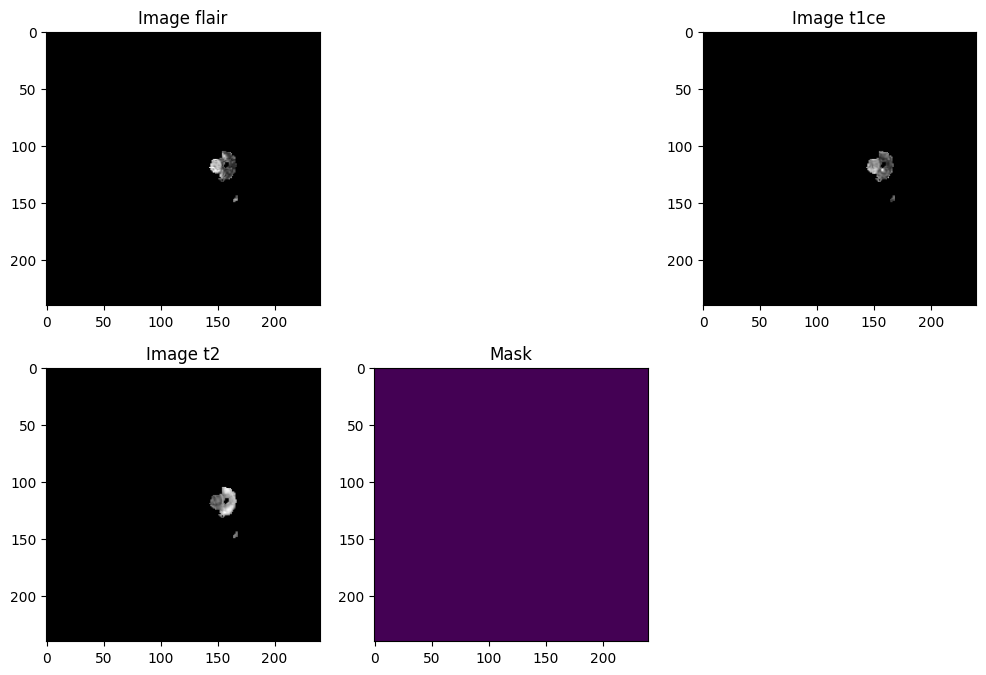

In [6]:
import random
n_slice=random.randint(0, test_image_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_image_mask[:,:,n_slice])
plt.title('Mask')
plt.show()



In [7]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
print(combined_x.shape)
combined_x = combined_x[56:184, 56:184, 13:141]
print(combined_x.shape)
test_image_mask = test_image_mask[56:184, 56:184, 13:141]
test_image_mask.shape

(240, 240, 155, 3)
(128, 128, 128, 3)


(128, 128, 128)

In [8]:
test_image_mask = to_categorical(test_image_mask, num_classes=4)
test_image_mask.shape

(128, 128, 128, 4)

# Now, let's process the data

In [13]:
t2_list = sorted(glob.glob('data/train/*/*t2.nii'))
t1ce_list = sorted(glob.glob('data/train/*/*t1ce.nii'))
flair_list = sorted(glob.glob('data/train/*/*flair.nii'))
mask_list = sorted(glob.glob('data/train/*/*seg.nii'))
print(len(t2_list))

369


In [ ]:
import os
for t in range(len(t2_list)):
    temp_image_t2 = nib.load(t2_list[t]).get_fdata().astype(np.float32)
    temp_image_t1ce = nib.load(t1ce_list[t]).get_fdata().astype(np.float32)
    temp_image_flair = nib.load(flair_list[t]).get_fdata().astype(np.float32)
    
    temp_image_mask = nib.load(mask_list[t]).get_fdata().astype(np.uint8)
    temp_image_mask[temp_image_mask == 4] = 3

    temp_image_t2 = scale(temp_image_t2)
    temp_image_t1ce = scale(temp_image_t1ce)
    temp_image_flair = scale(temp_image_flair)

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_image_mask = temp_image_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_image_mask, return_counts=True)

    val, counts = np.unique(temp_image_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me,", str(t))
        temp_image_mask= to_categorical(temp_image_mask, num_classes=4)

        np.save(os.path.join("./data/input_train/images", "image_"+str(t)+'.npy'), temp_combined_images)
        np.save(os.path.join("./data/input_train/masks", "mask_"+str(t)+'.npy'), temp_image_mask)
        
    else:
        print("I am useless")   


    



# The validation set is only used internally, so we will be making our own train/test split

In [23]:
import splitfolders  # or import split_folders

input_folder = './data/input_train'
output_folder = './data/input_val'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.80, .20), group_prefix=None) # default values